# I) Importation des données

In [1]:
# Importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

In [2]:
# Chargement des données
url = "https://www.dropbox.com/s/4np9xqqh3a2mjsq/df_train.csv.zip?dl=1"
df = pd.read_csv(url,
                 compression="zip",
                 sep=';',
                 index_col="SK_ID_CURR")

In [3]:
df.head()

,TARGET,FLAG_OWN_CAR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,...,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100002,1,0,406597.5,24700.5,351000.0,0.018801,-9461,-637.0,-3648.0,-2120,...,388.0,19.0,0.000000,53093.745,9251.775,219625.695,-49.0,-315.421053,NaN,NaN
100003,0,0,1293502.5,35698.5,1129500.0,0.003541,-16765,-1188.0,-1186.0,-291,...,179.0,25.0,0.000000,560835.360,6662.970,1618864.650,-544.0,-1385.320000,NaN,NaN
100004,0,1,135000.0,6750.0,135000.0,0.010032,-19046,-225.0,-4260.0,-2531,...,23.0,3.0,0.000000,10573.965,5357.250,21288.465,-727.0,-761.666667,NaN,NaN
100006,0,0,312682.5,29686.5,297000.0,0.008019,-19005,-3039.0,-9833.0,-2437,...,310.0,16.0,0.000000,691786.890,2482.920,1007153.415,-12.0,-271.625000,0.0,0.0
100007,0,0,513000.0,21865.5,513000.0,0.028663,-19932,-3038.0,-4311.0,-3458,...,303.0,63.0,452.384318,22678.785,0.180,806127.975,-14.0,-1032.242424,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 307511 entries, 100002 to 456255
Data columns (total 63 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   TARGET                                      307511 non-null  int64  
 1   FLAG_OWN_CAR                                307511 non-null  int64  
 2   AMT_CREDIT                                  307511 non-null  float64
 3   AMT_ANNUITY                                 307499 non-null  float64
 4   AMT_GOODS_PRICE                             307233 non-null  float64
 5   REGION_POPULATION_RELATIVE                  307511 non-null  float64
 6   DAYS_BIRTH                                  307511 non-null  int64  
 7   DAYS_EMPLOYED                               252137 non-null  float64
 8   DAYS_REGISTRATION                           307511 non-null  float64
 9   DAYS_ID_PUBLISH                             307511 non-null  int6

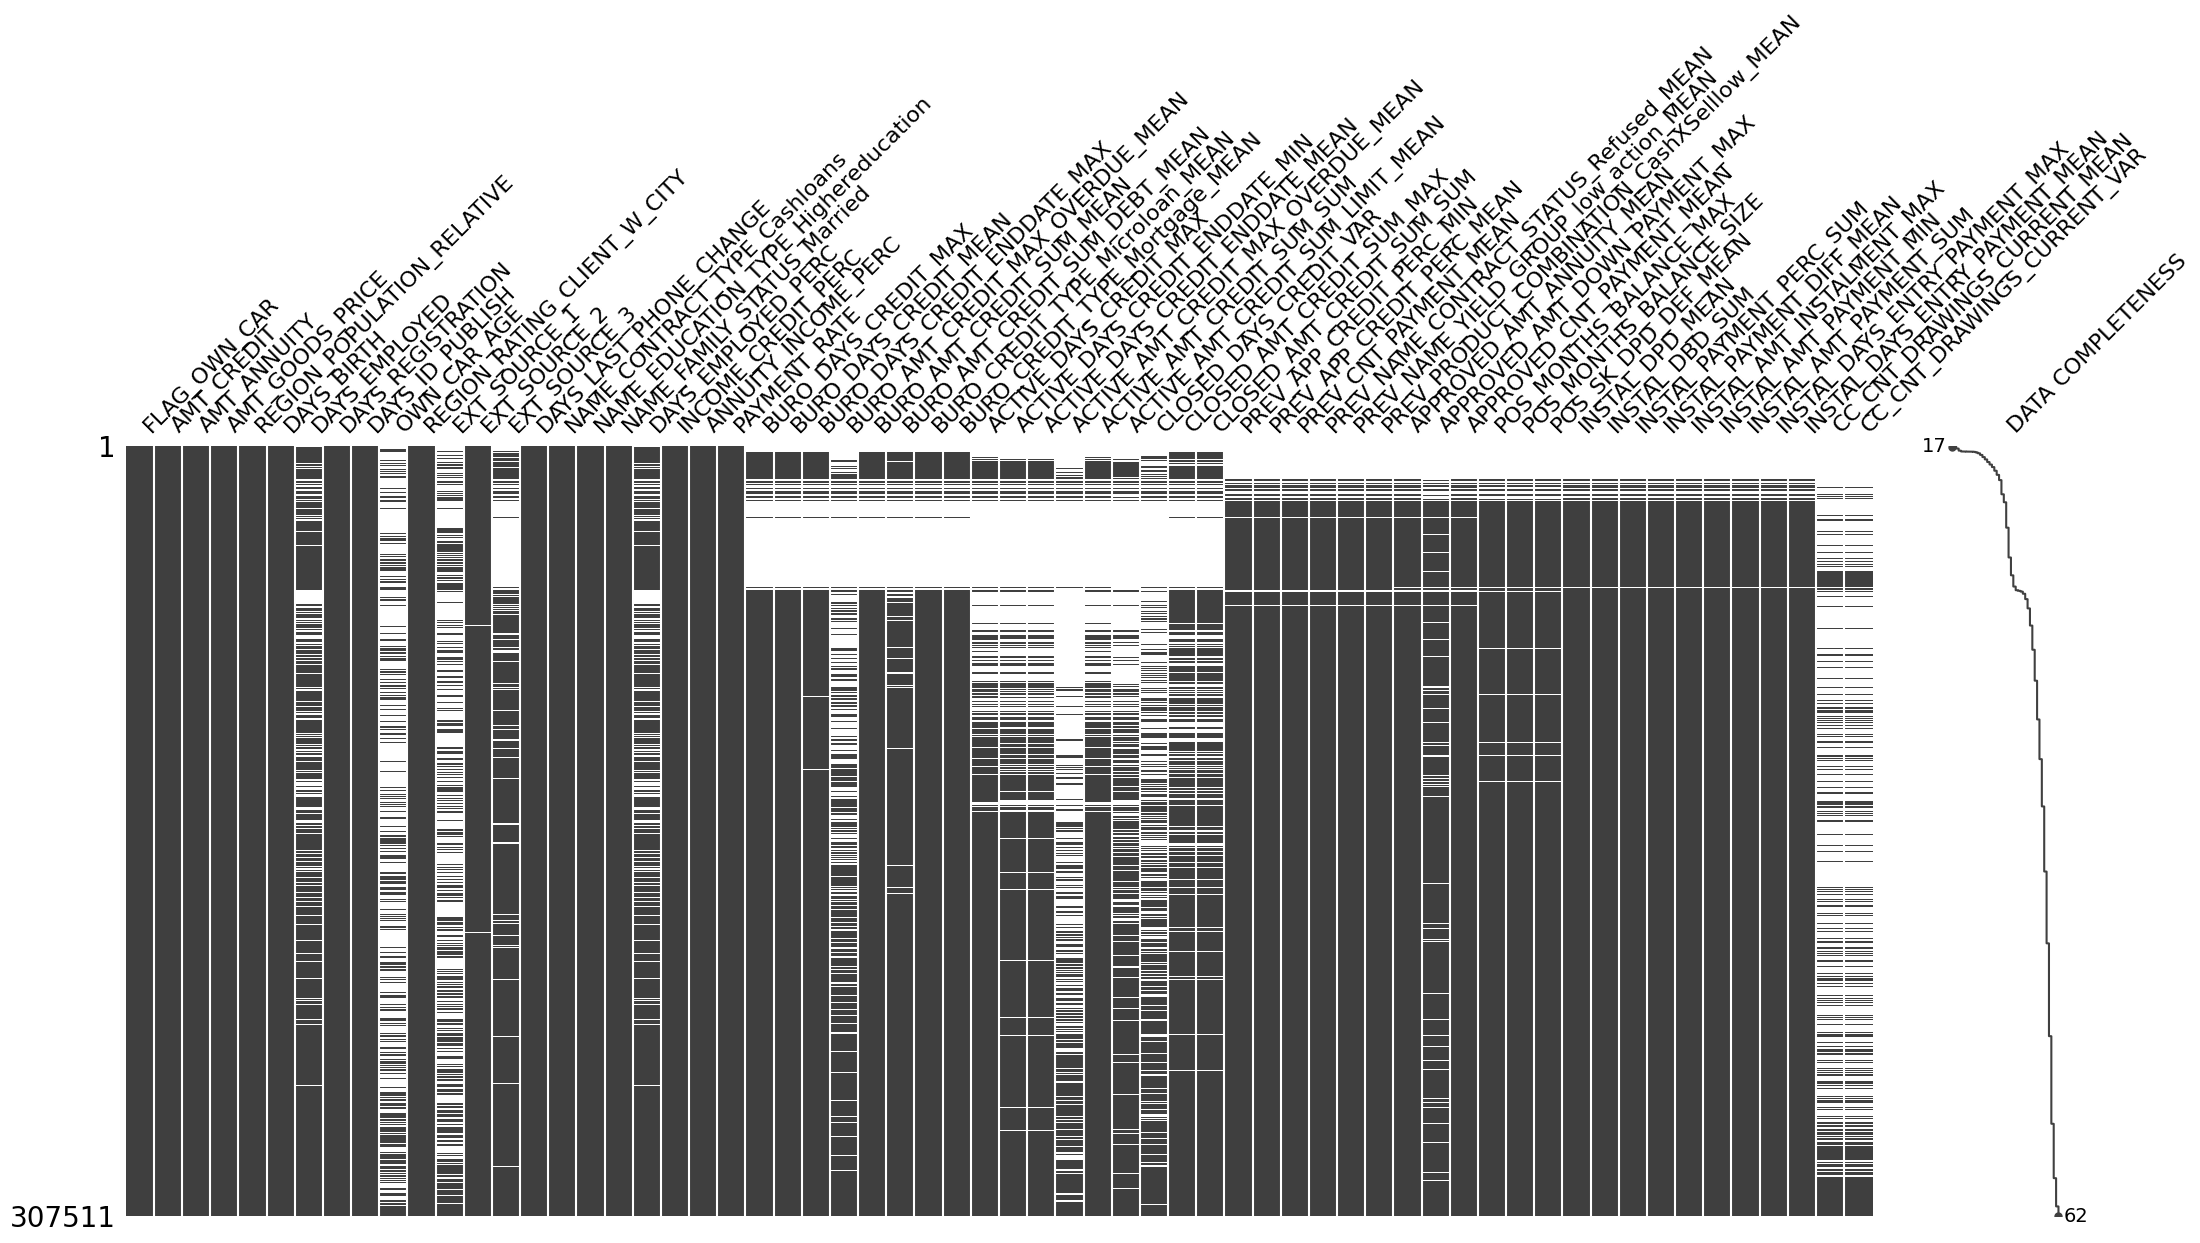

In [5]:
import missingno as msno

msno.matrix(df.drop(columns='TARGET'), labels=True, sort="ascending")
plt.show()

# II) Détermination du meilleur modèle (Pycaret)

## A) Stratégie d'under-sampling

In [6]:
df_undersampling = df.groupby('TARGET').sample(24825)

In [7]:
# init setup
from pycaret.classification import *

clf1 = setup(data=df_undersampling,
             target="TARGET",
             numeric_features=list(
                 df_undersampling.drop(columns='TARGET').columns),
             imputation_type='simple',
             numeric_imputation=0,
             fix_imbalance=False,
             fold_shuffle=True,
             fold=4,
             log_experiment=True,
             experiment_name='Credit_undersampling',
             log_plots=True,
             html=False)

                    Description                 Value
0                    Session id                  8809
1                        Target                TARGET
2                   Target type                Binary
3           Original data shape           (49650, 63)
4        Transformed data shape           (49650, 63)
5   Transformed train set shape           (34755, 63)
6    Transformed test set shape           (14895, 63)
7              Numeric features                    62
8      Rows with missing values                 98.7%
9                    Preprocess                  True
10              Imputation type                simple
11           Numeric imputation                     0
12       Categorical imputation                  mode
13               Fold Generator       StratifiedKFold
14                  Fold Number                     4
15                     CPU Jobs                    -1
16                      Use GPU                 False
17               Log Experim

2023/02/02 09:40:27 INFO mlflow.tracking.fluent: Experiment with name 'Credit_undersampling' does not exist. Creating a new experiment.


In [8]:
y = df.TARGET

In [9]:
len(y)

307511

In [10]:
def calculate_profit(y, y_pred):
    tn = np.where((y_pred == 0) & (y == 0), 3, 0)
    fn = np.where((y_pred == 0) & (y == 1), -10, 0)
    fp = np.where((y_pred == 1) & (y == 0), -1, 0)
    tp = np.where((y_pred == 1) & (y == 1), 0, 0)
    n = len(y)
    return np.sum([tn, fn, tp, fp])/n

In [11]:
add_metric('profit', 'Profit', calculate_profit)

Name                                                        Profit
Display Name                                                Profit
Score Function       <function calculate_profit at 0x7fc4438dc280>
Scorer                               make_scorer(calculate_profit)
Target                                                        pred
Args                                                            {}
Greater is Better                                             True
Multiclass                                                    True
Custom                                                        True
Name: profit, dtype: object

In [12]:
# compare models
best = compare_models()
results_best_us = pull()

                                    Model  Accuracy     AUC  Recall   Prec.  \
lightgbm  Light Gradient Boosting Machine    0.7055  0.7747  0.7039  0.7062   
gbc          Gradient Boosting Classifier    0.6998  0.7677  0.7064  0.6971   
rf               Random Forest Classifier    0.6927  0.7556  0.6776  0.6987   
ada                  Ada Boost Classifier    0.6899  0.7539  0.6925  0.6889   
et                 Extra Trees Classifier    0.6872  0.7508  0.6677  0.6948   
lda          Linear Discriminant Analysis    0.6822  0.7438  0.6821  0.6823   
ridge                    Ridge Classifier    0.6818  0.0000  0.6816  0.6819   
qda       Quadratic Discriminant Analysis    0.6356  0.6775  0.5746  0.6592   
lr                    Logistic Regression    0.6062  0.6460  0.5742  0.6136   
dt               Decision Tree Classifier    0.5908  0.5908  0.5887  0.5911   
nb                            Naive Bayes    0.5608  0.6217  0.8070  0.5410   
knn                K Neighbors Classifier    0.5495 

In [13]:
lightgbm_us = create_model('lightgbm')

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  Profit
Fold                                                                  
0       0.7150  0.7812  0.7219  0.7121  0.7170  0.4301  0.4301 -0.4738
1       0.6992  0.7676  0.7012  0.6983  0.6997  0.3983  0.3983 -0.5995
2       0.7071  0.7756  0.6999  0.7102  0.7050  0.4142  0.4142 -0.5722
3       0.7009  0.7745  0.6927  0.7042  0.6984  0.4017  0.4018 -0.6186
Mean    0.7055  0.7747  0.7039  0.7062  0.7050  0.4111  0.4111 -0.5660
Std     0.0062  0.0048  0.0109  0.0054  0.0073  0.0125  0.0125  0.0557


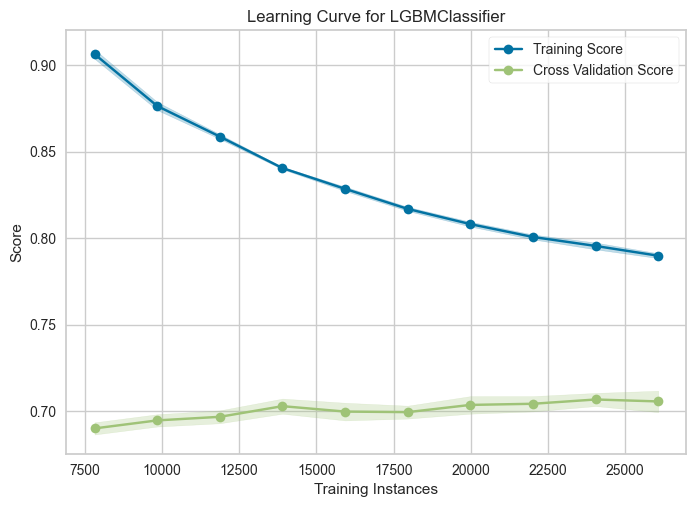

In [14]:
# plot model
plot_model(lightgbm_us, plot='learning')

In [15]:
# optimize threshold
optimize_threshold(lightgbm_us)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=8809, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

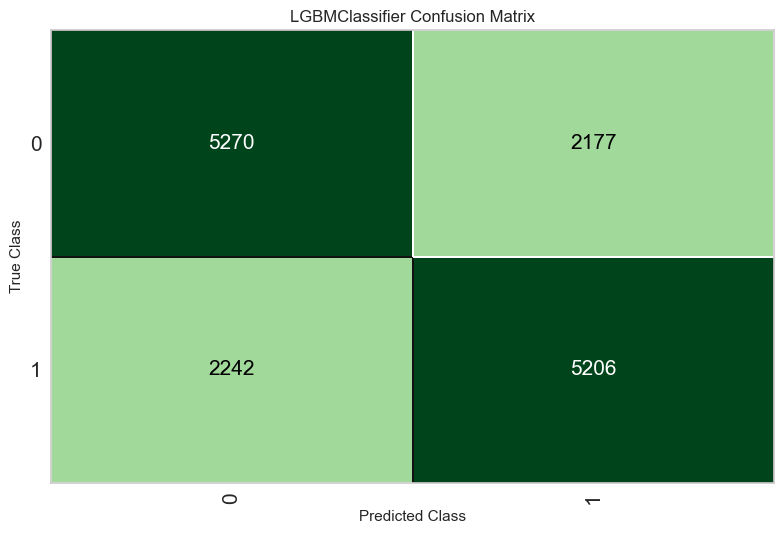

In [16]:
# plot model
plot_model(lightgbm_us, plot='confusion_matrix')

In [17]:
lightgbm_us_03 = create_model('lightgbm', probability_threshold=0.3)

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  Profit
Fold                                                                  
0       0.6551  0.7812  0.9134  0.6022  0.7259  0.3102  0.3623 -0.1391
1       0.6562  0.7676  0.8989  0.6051  0.7233  0.3125  0.3574 -0.1780
2       0.6498  0.7756  0.8997  0.5999  0.7198  0.2995  0.3458 -0.2021
3       0.6569  0.7745  0.9019  0.6053  0.7244  0.3138  0.3600 -0.1667
Mean    0.6545  0.7747  0.9035  0.6031  0.7234  0.3090  0.3564 -0.1715
Std     0.0028  0.0048  0.0059  0.0022  0.0022  0.0056  0.0063  0.0226


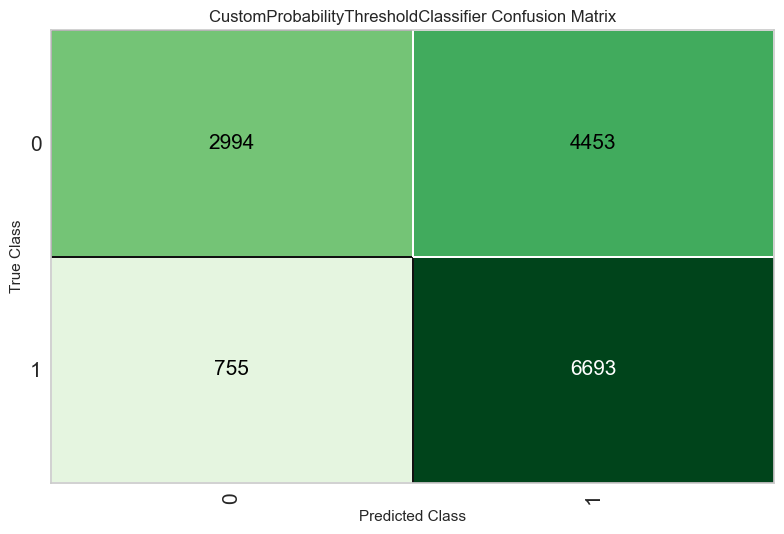

In [18]:
# plot model
plot_model(lightgbm_us_03, plot='confusion_matrix')

In [19]:
X = df.drop(columns="TARGET").fillna(value=0)
y = df.TARGET


y_pred_tot = predict_model(lightgbm_us_03, data=X)["prediction_label"]

calculate_profit(y, y_pred_tot)

0.11066921183307264

In [35]:
#results_best_us.to_csv('results_best_us.csv', index=False) 

## B) Stratégie d'over-sampling (SMOTE)

In [20]:
# init setup
from pycaret.classification import *

clf1 = setup(data=df,
             target="TARGET",
             numeric_features=list(df.drop(columns="TARGET").columns),
             imputation_type='simple',
             numeric_imputation=0,
             fold_shuffle=True,
             fold=3,
             fix_imbalance=True,
             log_experiment=True,
             experiment_name='Credit_oversampling_SMOTE',
             log_plots=True,
             html=False)

                    Description                      Value
0                    Session id                        168
1                        Target                     TARGET
2                   Target type                     Binary
3           Original data shape               (307511, 63)
4        Transformed data shape               (488014, 63)
5   Transformed train set shape               (395760, 63)
6    Transformed test set shape                (92254, 63)
7              Numeric features                         62
8      Rows with missing values                      98.8%
9                    Preprocess                       True
10              Imputation type                     simple
11           Numeric imputation                          0
12       Categorical imputation                       mode
13                Fix imbalance                       True
14         Fix imbalance method                      SMOTE
15               Fold Generator            StratifiedKFo

2023/02/02 09:47:51 INFO mlflow.tracking.fluent: Experiment with name 'Credit_oversampling_SMOTE' does not exist. Creating a new experiment.


In [21]:
add_metric('profit', 'Profit', calculate_profit)

Name                                                        Profit
Display Name                                                Profit
Score Function       <function calculate_profit at 0x7fc4438dc280>
Scorer                               make_scorer(calculate_profit)
Target                                                        pred
Args                                                            {}
Greater is Better                                             True
Multiclass                                                    True
Custom                                                        True
Name: profit, dtype: object

In [22]:
# compare models
best = compare_models()
results_best_os = pull()

                                    Model  Accuracy     AUC  Recall   Prec.  \
dummy                    Dummy Classifier    0.9193  0.5000  0.0000  0.0000   
lightgbm  Light Gradient Boosting Machine    0.9154  0.7558  0.0684  0.3706   
et                 Extra Trees Classifier    0.9145  0.7397  0.0769  0.3616   
rf               Random Forest Classifier    0.9125  0.7275  0.0684  0.3093   
gbc          Gradient Boosting Classifier    0.9049  0.7225  0.1118  0.2787   
ada                  Ada Boost Classifier    0.8765  0.7110  0.2039  0.2175   
dt               Decision Tree Classifier    0.8246  0.5490  0.2202  0.1365   
svm                   SVM - Linear Kernel    0.8076  0.0000  0.2303  0.1525   
ridge                    Ridge Classifier    0.6872  0.0000  0.6785  0.1603   
lda          Linear Discriminant Analysis    0.6872  0.7446  0.6785  0.1603   
knn                K Neighbors Classifier    0.6804  0.5539  0.3711  0.1002   
lr                    Logistic Regression    0.6361 

In [23]:
lightgbm_os = create_model('lightgbm')

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  Profit
Fold                                                                  
0       0.9154  0.7596  0.0735  0.3773  0.1231  0.0994  0.1376  1.9706
1       0.9155  0.7561  0.0603  0.3591  0.1032  0.0819  0.1197  1.9645
2       0.9155  0.7518  0.0713  0.3755  0.1198  0.0966  0.1350  1.9699
Mean    0.9154  0.7558  0.0684  0.3706  0.1154  0.0926  0.1308  1.9683
Std     0.0000  0.0032  0.0058  0.0082  0.0087  0.0077  0.0079  0.0027


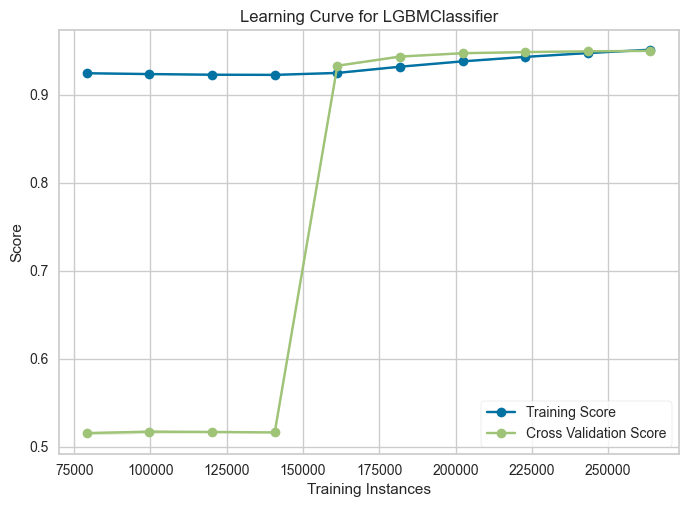

In [24]:
# plot model
plot_model(lightgbm_os, plot='learning')

In [25]:
# optimize threshold
optimize_threshold(lightgbm_os)

CustomProbabilityThresholdClassifier(boosting_type='gbdt', class_weight=None,
                                     classifier=LGBMClassifier(boosting_type='gbdt',
                                                               class_weight=None,
                                                               colsample_bytree=1.0,
                                                               importance_type='split',
                                                               learning_rate=0.1,
                                                               max_depth=-1,
                                                               min_child_samples=20,
                                                               min_child_weight=0.001,
                                                               min_split_gain=0.0,
                                                               n_estimators=100,
                                                               n_jobs=-1,
                                                               num_leaves=31,
                                                               objective=None,
                                                               random_state=1...
                                                               subsample_freq=0),
                                     colsample_bytree=1.0,
                                     importance_type='split', learning_rate=0.1,
                                     max_depth=-1, min_child_samples=20,
                                     min_child_weight=0.001, min_split_gain=0.0,
                                     n_estimators=100, n_jobs=-1, num_leaves=31,
                                     objective=None, probability_threshold=0.9,
                                     random_state=168, reg_alpha=0.0,
                                     reg_lambda=0.0, silent='warn',
                                     subsample=1.0, subsample_for_bin=200000,
                                     subsample_freq=0)

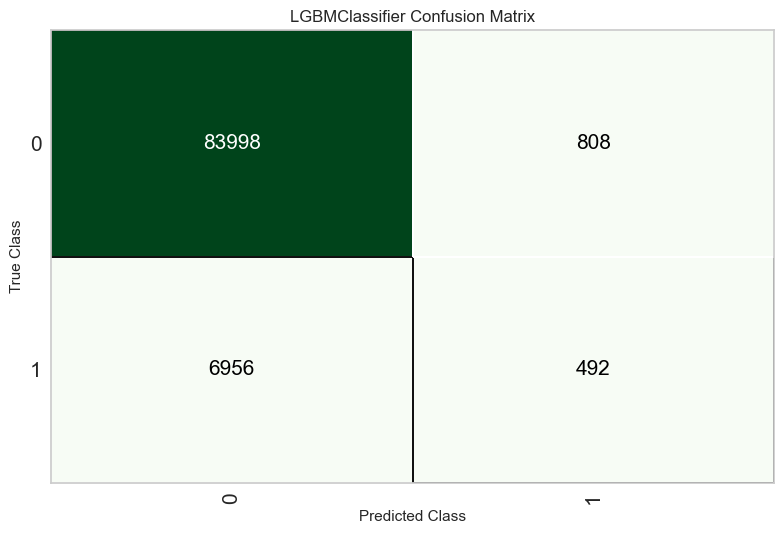

In [26]:
# plot model
plot_model(lightgbm_os, plot='confusion_matrix')

In [27]:
lightgbm_os_4 = create_model('lightgbm', probability_threshold=0.4)

      Accuracy     AUC  Recall   Prec.      F1   Kappa     MCC  Profit
Fold                                                                  
0       0.9084  0.7596  0.1395  0.3375  0.1974  0.1576  0.1751  1.9746
1       0.9094  0.7561  0.1269  0.3372  0.1844  0.1467  0.1666  1.9725
2       0.9083  0.7518  0.1350  0.3326  0.1921  0.1526  0.1702  1.9721
Mean    0.9087  0.7558  0.1338  0.3358  0.1913  0.1523  0.1706  1.9731
Std     0.0005  0.0032  0.0052  0.0022  0.0053  0.0044  0.0035  0.0011


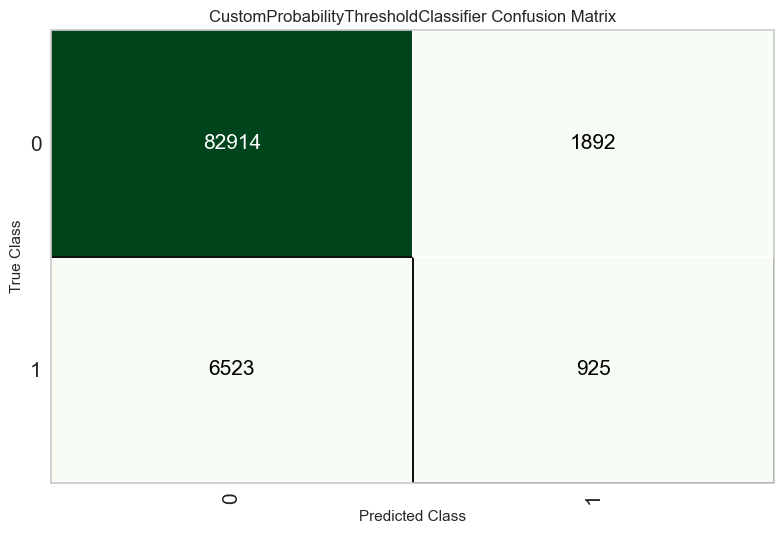

In [28]:
# plot model
plot_model(lightgbm_os_4, plot='confusion_matrix')

In [29]:
X = df.drop(columns="TARGET").fillna(value=0)
y = df.TARGET


y_pred_tot = predict_model(lightgbm_os_4, data=X)["prediction_label"]

calculate_profit(y, y_pred_tot)

1.080787353948314

In [34]:
#results_best_os.to_csv('results_best_os.csv', index=False) 

# III) Optimisation du meilleur modèle

In [31]:
import optuna
import mlflow

from optuna.integration.mlflow import MLflowCallback
from imblearn.over_sampling import SMOTE
from optuna.samplers import TPESampler
from mlflow.models.signature import infer_signature
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, roc_curve, RocCurveDisplay, ConfusionMatrixDisplay
from lightgbm import LGBMClassifier
from optuna.visualization import plot_contour, plot_param_importances, plot_optimization_history


# -- Custom metric :

def calculate_profit(y_true, y_pred, **kwargs):
    tn = np.where((y_pred == 0) & (y_true == 0), 3, 0)
    fn = np.where((y_pred == 0) & (y_true == 1), -10, 0)
    fp = np.where((y_pred == 1) & (y_true == 0), -1, 0)
    tp = np.where((y_pred == 1) & (y_true == 1), 0, 0)
    n = len(y_true)
    return np.sum([tn, fn, tp, fp])/n


profit_scorer = make_scorer(calculate_profit, greater_is_better=True)


# -- Construct Features + target

X = df.drop(columns="TARGET").fillna(0)
y = df.TARGET


# -- Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

# -- Balancing data  > Train test split and lightgbm take into account unbalanced data


# -- Creating the model data (over sampling)

# Modification of the threshold in the LMGBclassifier class
class MyLGBClassifier(LGBMClassifier):
    def predict(self, X, threshold=0.4, raw_score=False, num_iteration=None,
                pred_leaf=False, pred_contrib=False, **kwargs):
        result = super(MyLGBClassifier, self).predict_proba(X, raw_score, num_iteration,
                                                            pred_leaf, pred_contrib, **kwargs)
        predictions = [1 if p > threshold else 0 for p in result[:, 0]]
        return predictions


credit_clf = LGBMClassifier(objective="binary",
                            n_jobs=-1, is_unbalance=True)

# -- Registering of model signature
Signature = infer_signature(X_train, y_train)

# -- Setting up mlflow callback
mlflc = MLflowCallback(create_experiment=True,
                       metric_name="Profit", mlflow_kwargs={"nested": True})


# -- Define the objective function
@mlflc.track_in_mlflow()
def objective(trial, Profit_max=0):
    # -- Instantiate estimator model
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 10.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 512),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.1, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.1, 1.0),
        'subsample_freq': trial.suggest_int('subsample_freq', 1, 15),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 256)
    }

    # -- preparing model

    credit_clf.set_params(**param_grid)

    mlflow.log_param("Optuna_trial_num", trial.number)
    mlflow.log_params(param_grid)

    mlflow.lightgbm.log_model(
        lgb_model=credit_clf,
        artifact_path="lgbm-model",
        signature=Signature)

    # -- Evaluating the usual scores with cross-validation

    scoring = {'roc_auc': 'roc_auc',
               'accuracy': 'accuracy',
               'f1': 'f1',
               "recall": "recall",
               "precision": "precision",
               "profit": profit_scorer
               }

    scores = cross_validate(credit_clf,
                            X_train,
                            y_train,
                            cv=3,
                            scoring=scoring,
                            return_estimator=True, n_jobs=-1
                            )

    profit_CV = scores["test_profit"].mean()

    mlflow.log_metrics({"CV-AUC": scores['test_roc_auc'].mean(),
                        "CV-F1": scores['test_f1'].mean(),
                        "CV-Accuracy": scores['test_accuracy'].mean(),
                        "CV-Precision": scores['test_precision'].mean(),
                        "CV-Recall": scores['test_recall'].mean(),
                        "CV_profit": profit_CV})

    # -- Fit the model and calculate profit on the best threshold

    credit_clf.fit(X_train, y_train)

    # -- Analysis of the model in the test set
        # Roc curve
    rc = RocCurveDisplay.from_estimator(credit_clf, X_test, y_test)
    mlflow.log_figure(rc.figure_, 'Test_ROC_AUC.png')
    plt.close()

        # Confusion matrix
    y_pred = (credit_clf.predict_proba(X_test)[:, 1] >= 0.4).astype(bool)

    cm = ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                                 cmap=plt.cm.Greens,
                                                 colorbar=False
                                                 )
    plt.grid(False)
    plt.title("Confusion matrix\n(Decision Threshold = 0.4)")
    mlflow.log_figure(cm.figure_, 'Test_confusion_matrix.png')
    plt.close()

    profit_test = calculate_profit(y_test, y_pred)
    mlflow.log_metric("Test_profit", profit_test)

    return profit_CV


study = optuna.create_study(
    study_name="Optuna_lgbm", direction="maximize", sampler=TPESampler())
study.optimize(objective, n_trials=30, callbacks=[mlflc])

mlflow.end_run()

with mlflow.start_run(run_name="Optuna_results") as run:

    fig1 = plot_optimization_history(study)
    mlflow.log_figure(fig1, "1_plot_history.html")

    fig2 = plot_contour(study)
    mlflow.log_figure(fig2, "2_plot_contour.html")

    fig3 = plot_param_importances(study)
    mlflow.log_figure(fig3, "3_param_imp.html")

[I 2023-02-02 11:28:49,652] A new study created in memory with name: Optuna_lgbm
2023/02/02 11:28:49 INFO mlflow.tracking.fluent: Experiment with name 'Optuna_lgbm' does not exist. Creating a new experiment.
[I 2023-02-02 11:31:46,768] Trial 0 finished with value: 1.7543331935650366 and parameters: {'reg_alpha': 0.005489936809584259, 'reg_lambda': 1.7012786461125304, 'num_leaves': 299, 'colsample_bytree': 0.25453489715857575, 'subsample': 0.5403539851382234, 'subsample_freq': 8, 'min_child_samples': 239}. Best is trial 0 with value: 1.7543331935650366.
[I 2023-02-02 11:34:07,724] Trial 1 finished with value: 1.893580715329947 and parameters: {'reg_alpha': 1.970526055841136e-06, 'reg_lambda': 2.3861371788657085e-05, 'num_leaves': 490, 'colsample_bytree': 0.9189677786834165, 'subsample': 0.7954659210824042, 'subsample_freq': 7, 'min_child_samples': 229}. Best is trial 1 with value: 1.893580715329947.
[I 2023-02-02 11:35:24,290] Trial 2 finished with value: 1.7456099441972863 and paramete

In [32]:
# Model finalization : training on the whole dataset
from lightgbm import plot_importance

with mlflow.start_run(run_name="Finalized model") as run:

    credit_clf_opti = LGBMClassifier(objective="binary",
                                     n_jobs=-1,
                                     **study.best_params, is_unbalance=True).fit(X, y)

    mlflow.lightgbm.log_model(
        lgb_model=credit_clf_opti,
        artifact_path="Credit_clf_final",
        signature=Signature)

    mlflow.log_params(credit_clf_opti.get_params())

    # Feature importance of finalized model
    feature_imp = pd.DataFrame(sorted(zip(
        credit_clf_opti.feature_importances_, X.columns), reverse=True), columns=['Value', 'Feature'])
    feature_imp["pct"] = (feature_imp.Value / sum(feature_imp.Value)) * 100
    feature_imp["pct_cum"] = np.cumsum(feature_imp["pct"])

    PI = plt.figure(figsize=(15, 6), dpi=100, constrained_layout=True)
    plt.stem(feature_imp['Value'])
    plt.xticks(range(0, len(feature_imp.index)),
               feature_imp['Feature'], rotation=90)
    plt.ylim(0, feature_imp['Value'].max()+50)
    plt.xlabel("Feature")
    plt.ylabel('Importance value')

    mlflow.log_figure(PI.figure, 'Plot_importance.png')
    plt.close()

# IV) Interprétabilité du modèle (Globale et locale)

In [38]:
# Chargement du modèle
import pickle
logged_model = "/Users/dubois/Library/CloudStorage/OneDrive-Personnel/Documents/Data_Scientist/Projet_7/Dubois_Clement_2_dossier_code_012022/apps/OC-DS-P7-frontend/model.pkl"
Credit_clf_final = pickle.load(open(logged_model, 'rb'))

## Interprétation globale

In [39]:
# Sample of the data
X = df.groupby('TARGET', as_index=False).apply(lambda s: s.sample(
    10000, random_state=0)).fillna(0).drop(columns='TARGET')
# compute SHAP values
explainer = shap.TreeExplainer(Credit_clf_final)
shap_values = explainer.shap_values(X)

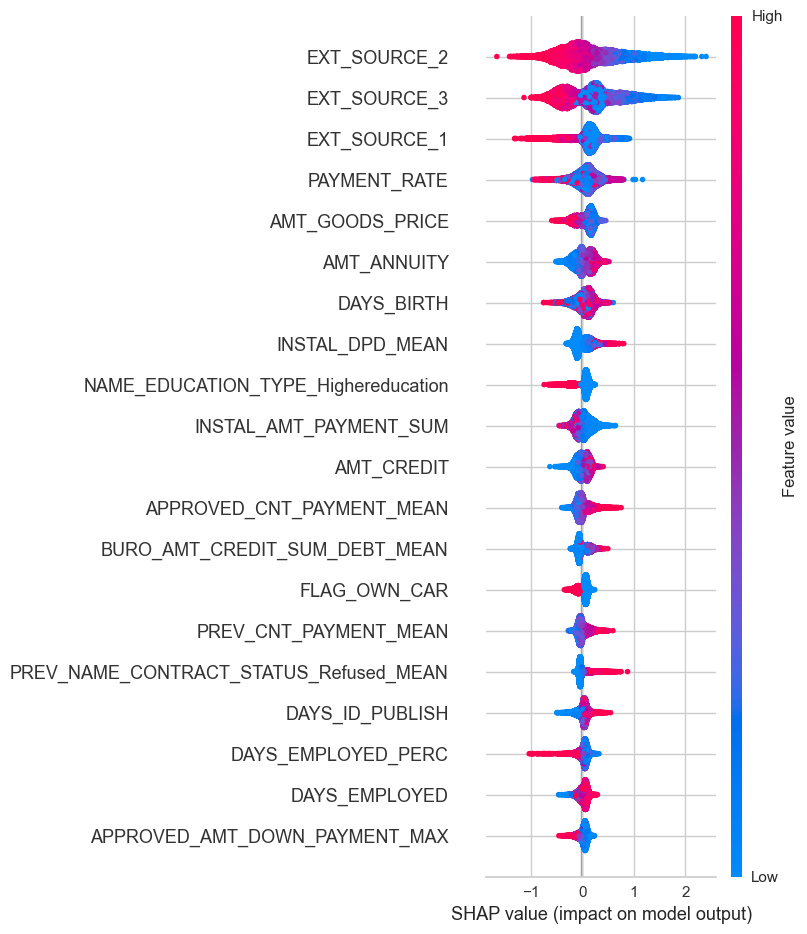

In [40]:
shap.summary_plot(shap_values[1], X)

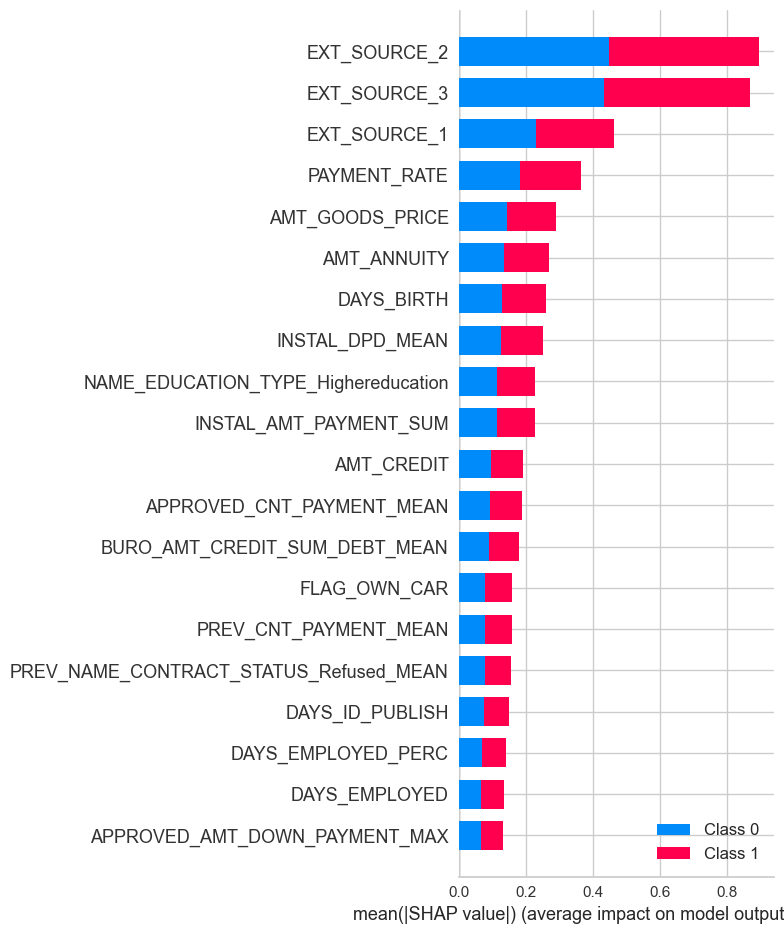

In [41]:
shap.summary_plot(shap_values, X)

## Interprétation locale

In [42]:
X.reset_index().set_index('SK_ID_CURR').drop(columns='level_0')

,FLAG_OWN_CAR,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,...,INSTAL_DBD_SUM,INSTAL_PAYMENT_PERC_SUM,INSTAL_PAYMENT_DIFF_MEAN,INSTAL_AMT_INSTALMENT_MAX,INSTAL_AMT_PAYMENT_MIN,INSTAL_AMT_PAYMENT_SUM,INSTAL_DAYS_ENTRY_PAYMENT_MAX,INSTAL_DAYS_ENTRY_PAYMENT_MEAN,CC_CNT_DRAWINGS_CURRENT_MEAN,CC_CNT_DRAWINGS_CURRENT_VAR
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
145685,0,573408.0,29407.5,495000.0,0.046220,-21939,0.0,-2724.0,-5244,0.0,...,882.0,148.991234,-622.408437,51010.425,67.500,885037.140,-32.0,-1663.659722,0.020833,0.020614
193090,0,225000.0,10039.5,225000.0,0.015221,-10613,-213.0,-9165.0,-2880,0.0,...,155.0,5.000000,0.000000,139605.795,23105.250,232026.795,-390.0,-470.000000,0.000000,0.000000
140528,1,715095.0,48109.5,675000.0,0.014464,-17505,-6642.0,-6511.0,-1061,24.0,...,318.0,22.052776,-5000.000000,133776.495,19832.445,791650.440,-90.0,-453.555556,0.000000,0.000000
348643,0,765000.0,22365.0,765000.0,0.006671,-13780,-3342.0,-1096.0,-3583,0.0,...,304.0,51.000000,0.000000,54205.740,70.920,417931.650,-5.0,-484.862745,0.666667,4.933333
296975,1,528633.0,38817.0,472500.0,0.020713,-16880,-2551.0,-2778.0,-427,33.0,...,360.0,36.000000,1705.877308,761836.635,6.930,1375741.980,-344.0,-1451.128205,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261105,0,552555.0,33934.5,477000.0,0.020713,-17305,-4376.0,-4768.0,-856,0.0,...,49.0,9.000000,0.000000,227908.350,18516.915,376043.670,-95.0,-218.444444,0.000000,0.000000
442533,0,278460.0,21676.5,225000.0,0.035792,-18091,-5293.0,-2663.0,-1631,0.0,...,434.0,13.000000,1748.458929,756060.480,2088.810,850318.965,-178.0,-1765.642857,0.000000,0.000000
264764,1,454500.0,21865.5,454500.0,0.007020,-12058,-3185.0,-6064.0,-3426,15.0,...,129.0,28.843625,-15653.044286,326483.460,320.895,1175249.385,-161.0,-708.571429,0.000000,0.000000


In [43]:
explainer = shap.TreeExplainer(
    Credit_clf_final, df.drop(
        columns="TARGET").fillna(0))

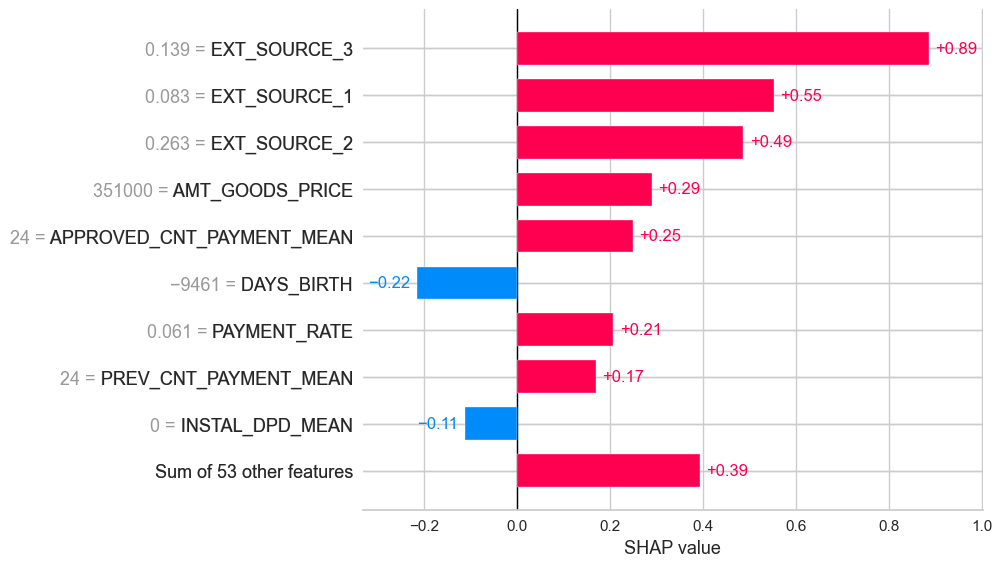

In [44]:
shap.plots.bar(
    explainer(
        df.drop(columns='TARGET').loc[100002]),
    show=False)

# IV) Analyse du Data Drift

In [45]:
url = "https://www.dropbox.com/s/r1p43l7ad230zjg/df_test.csv.zip?dl=1"
df_new = pd.read_csv(url,
    compression="zip",
    sep=';',
    index_col="SK_ID_CURR")

In [46]:
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(current_data=df_new.sample(40000), reference_data=df.drop(
    columns='TARGET').sample(40000), column_mapping=None)
data_drift_report.save_html("data_drift_report.html")